Training Accuracy: 50.45%
 predictions.csv created successfully


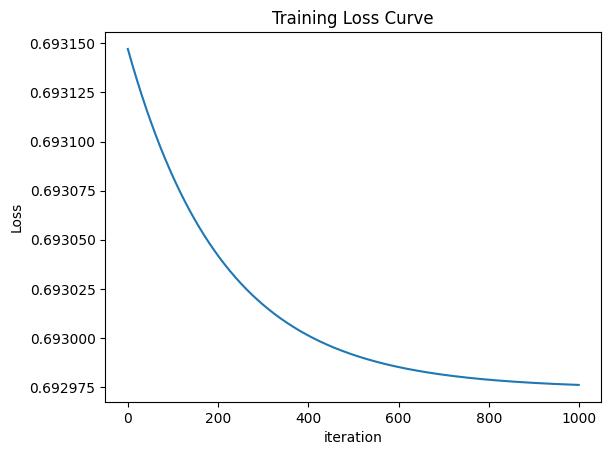

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load data

train_data = pd.read_csv(r"C:\Users\Samaira Singh\Downloads\MANAS\crime_train.csv")
test_data = pd.read_csv(r"C:\Users\Samaira Singh\Downloads\MANAS\crime_test.csv")


train_data["closed"].value_counts()
train_data['closed'] = train_data['closed'].apply(
    lambda x: 1 if str(x).strip().lower() == 'yes' else 0
)

y_train = train_data['closed'].values.reshape(-1, 1)


# 3. DROP TARGET FROM FEATURES

train_features = train_data.drop('closed', axis=1)

#  IMPORTANT FIX: drop 'closed' from test IF PRESENT
if 'closed' in test_data.columns:
    test_features = test_data.drop('closed', axis=1)
else:
    test_features = test_data.copy()


# 4. LABEL ENCODE CATEGORICAL COLUMNS (MEMORY SAFE)

for col in train_features.columns:
    if train_features[col].dtype == 'object':
        combined = pd.concat(
            [train_features[col], test_features[col]],
            axis=0
        )
        encoded, _ = pd.factorize(combined)

        train_features[col] = encoded[:len(train_features)]
        test_features[col] = encoded[len(train_features):]


# 5. CONVERT TO NUMPY

X_train = train_features.values.astype(float)
X_test = test_features.values.astype(float)


# 6. NORMALIZATION

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


# 7. ADD BIAS

X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))


# 8. LOGISTIC REGRESSION (FROM SCRATCH)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(y, y_hat, w, lambda_):
    m = len(y)
    log_loss = -np.mean(
        y * np.log(y_hat + 1e-9) +
        (1 - y) * np.log(1 - y_hat + 1e-9)
    )
    
    # L2 regularization (exclude bias w[0])
    l2_penalty = (lambda_ / (2 * m)) * np.sum(w[1:] ** 2)
    
    return log_loss + l2_penalty


def train_lr(X, y, lr=0.01, epochs=1000, lambda_=0.1):
    m, n = X.shape
    w = np.zeros((n, 1))
    losses = []

    for _ in range(epochs):
        # Forward pass
        y_hat = sigmoid(X @ w)

        # Gradient of log loss
        grad = (X.T @ (y_hat - y)) / m

        # L2 regularization gradient (exclude bias)
        grad[1:] += (lambda_ / m) * w[1:]

        # Update weights
        w -= lr * grad

        # Track regularized loss
        losses.append(loss(y, y_hat, w, lambda_))

    return w, losses



#  TRAIN

weights, losses = train_lr(
    X_train,
    y_train,
    lr=0.01,
    epochs=1000,
    lambda_=0.1
)

#  PREDICT

def predict(X, w):
    return (sigmoid(X @ w) >= 0.5).astype(int)

preds = predict(X_test, weights)
preds = ["Yes" if p == 1 else "No" for p in preds.flatten()]

train_preds = predict(X_train, weights)

training_accuracy = np.mean(train_preds == y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

#  SAVE OUTPUT

output = test_features.copy()
output['closed_predicted'] = preds
output.to_csv("predictions.csv", index=False)

print(" predictions.csv created successfully")


# 12. LOSS CURVE

plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()